In [1]:
import random
import numpy as np
import pandas as pd

from functools import partial
from esn_tarnet import *
from feature_select import *
from s_learner import *
from t_learner import *
from tarnet import *

def set_seed(seed):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
set_seed(42)



In [ ]:
country_code = 'SEA'

In [6]:
# !rm -r /mlx_devbox/users/wangyuxin.huoshan/playground/bonus_train_data/buy_again_train_valid
# !rm -r /mlx_devbox/users/wangyuxin.huoshan/playground/bonus_train_data/buy_again_train_valid._COPYING_
# !rm -r /mlx_devbox/users/wangyuxin.huoshan/playground/bonus_train_data/aa._COPYING_

!hdfs dfs -get hdfs://harunasg/home/byte_ecom_product_ds_sg/buy_again_test /mlx_devbox/users/wangyuxin.huoshan/playground/bonus_train_data


W2025-10-09 18:58:35.153055 InputStreamImpl.cpp:934 p6307-t6571] InputStreamImpl: failed to read Block: [block pool ID: BP-1252618227-0.0.0.0-1752740294593 block ID 1080084678_6346164] file /home/byte_ecom_product_ds_sg/buy_again_test/part-00002-9f484a7b-cd2f-4eef-9b8d-4a6f528ae975-c000.snappy.parquet from Datanode: dc53-p2a-t314-n022.byted.org(FDBD:DC53:2A:314::22), FastSwitchReadStrategy.h: 51: java.io.IOException: Detect slow read. Try to failover to next node.
, retry read again from another Datanode.
W2025-10-09 18:58:35.202191 InputStreamImpl.cpp:934 p6307-t6577] InputStreamImpl: failed to read Block: [block pool ID: BP-1252618227-0.0.0.0-1752740294593 block ID 1080084663_6346149] file /home/byte_ecom_product_ds_sg/buy_again_test/part-00008-9f484a7b-cd2f-4eef-9b8d-4a6f528ae975-c000.snappy.parquet from Datanode: dc53-p2a-t338-n029.byted.org(FDBD:DC53:2A:338::29), FastSwitchReadStrategy.h: 51: java.io.IOException: Detect slow read. Try to failover to next node.
, retry read again f

In [ ]:
# !rm -r /mlx_devbox/users/wangyuxin.huoshan/playground/bonus_train_data/aftersale_train_valid_{country_code}
# !rm -r /mlx_devbox/users/wangyuxin.huoshan/playground/bonus_train_data/aftersale_test_{country_code}

# !hdfs dfs -get hdfs://harunasg/home/byte_ecom_product_ds_sg/aftersale_train_valid_{country_code} /mlx_devbox/users/wangyuxin.huoshan/playground/bonus_train_data/
# !hdfs dfs -get hdfs://harunasg/home/byte_ecom_product_ds_sg/aftersale_test_{country_code} /mlx_devbox/users/wangyuxin.huoshan/playground/bonus_train_data/

In [2]:
#读取特征列表
!rm -r /mlx_devbox/users/wangyuxin.huoshan/playground/bonus_train_data/feature_list_buy_again.pkl
!hdfs dfs -get hdfs://harunasg/home/byte_ecom_product_ds_sg/feature_list_buy_again.pkl /mlx_devbox/users/wangyuxin.huoshan/playground/bonus_train_data/
import pickle
with open(f'/mlx_devbox/users/wangyuxin.huoshan/playground/bonus_train_data/feature_list_buy_again.pkl', 'rb') as f:
    feature_list = pickle.load(f)
print(len(feature_list))

604


In [3]:
df = pd.read_parquet(f'/mlx_devbox/users/wangyuxin.huoshan/playground/bonus_train_data/buy_again_train_valid',columns=feature_list+['is_click']).fillna(0)
df_test = pd.read_parquet(f'/mlx_devbox/users/wangyuxin.huoshan/playground/bonus_train_data/buy_again_test',columns=feature_list+['is_click']).fillna(0)

# for column in df.columns:
#     if df[column].dtype != 'float':
#         df[column] = df[column].astype('float')

# df['gmv_label'] = df['gmv'].apply(lambda x: 1 if x>0 else 0)

# df.groupby('is_treatment').agg(
#         gmv_label_pos_rate=('gmv_label', 'mean'),  # 正例比例 = 平均值（因为是0/1）
#         gmv_mean=('gmv', 'mean'),                  # gmv 均值
#         count=('gmv_label', 'size')                # 样本数（可选）
#     ).reset_index()



In [ ]:
top_features = features_select(df,feature_list,'gmv_label',100,'/mlx_devbox/users/wangyuxin.huoshan/playground/bonus_train_data/' + country_code + '_feature_list_aftersale_gmv_label_selected.pkl','classification')

In [ ]:
top_features = features_select(df,feature_list,'gmv',100,'/mlx_devbox/users/wangyuxin.huoshan/playground/bonus_train_data/' + country_code + '_feature_list_aftersale_gmv_selected.pkl','regression')


In [11]:
for column in df.columns:
    if df[column].dtype != 'float':
        df[column] = df[column].astype('float')

In [ ]:
for column in df.columns:
    if df[column].dtype != 'float':
        df[column] = df[column].astype('float')

In [4]:
import xgboost as xgb
import pandas as pd
from sklearn.datasets import load_breast_cancer
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score

model_full = xgb.XGBClassifier(n_estimators = 150,use_label_encoder=False, eval_metric='logloss',n_jobs=-1)
model_full.fit(df[feature_list].values, df['is_click'].values)

/root/anaconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [19:33:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=-1,
              num_parallel_tree=None, ...)

In [17]:

# 3. 预测并计算原始模型AUC
y_pred_proba_full = model_full.predict_proba(df_test[feature_list].values)[:, 1]
auc_full = roc_auc_score(df_test['is_click'].values, y_pred_proba_full)
print(f"AUC with all features: {auc_full:.4f}")


AUC with all features: 0.6664


In [ ]:
model_full.feature_importances

In [20]:
def normalize_col(s):
    if isinstance(s, bytes):
        try:
            s = s.decode("utf-8")
        except UnicodeDecodeError:
            s = s.decode("cp1252", errors="replace")
    # 替换不可见或特殊字符
    return (
        str(s)
        .encode("utf-8", errors="ignore")
        .decode("utf-8")
        .replace("—", "-")
        .replace("–", "-")
        .strip()
    )

    

In [25]:
feature_list = [normalize_col(_) for _ in feature_list]

/tmp/ipykernel_6710/1450526188.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


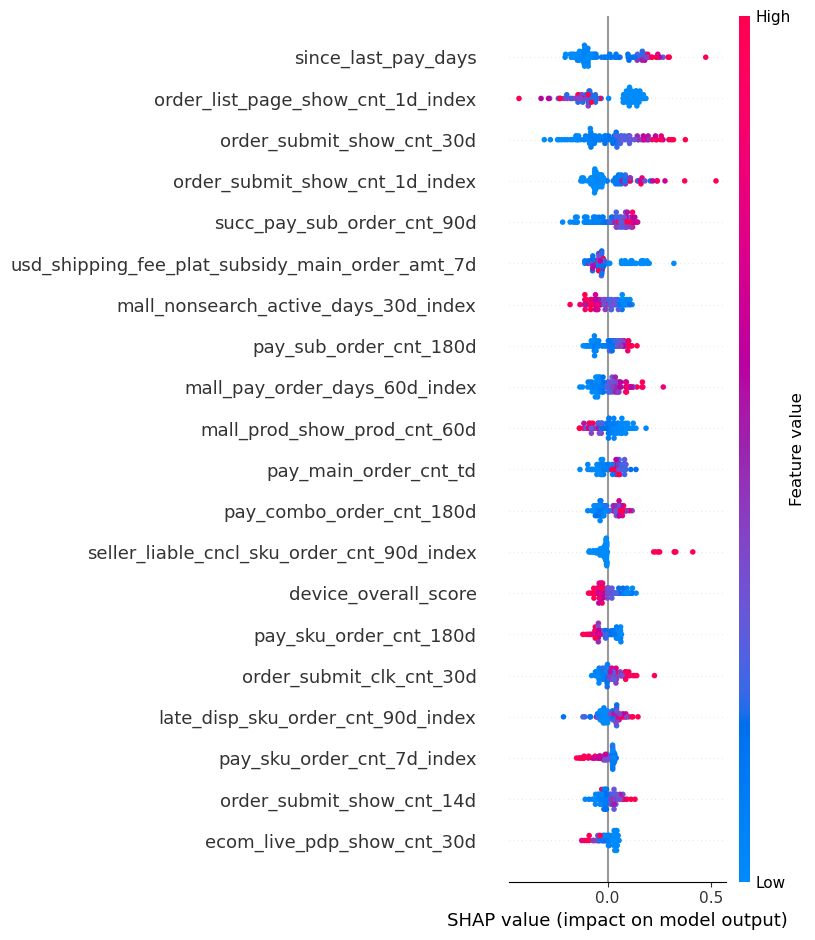

In [5]:

X_train = df.sample(n=100)[feature_list].values
X_test = df_test.sample(n=100)[feature_list].values
import shap
explainer = shap.TreeExplainer(model_full,X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(
    shap_values,         # 解释结果
    X_test,              # 原始输入数据
    feature_names=feature_list  # 可选：特征名
)

